In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import kagglehub


path = kagglehub.dataset_download("gpiosenka/butterfly-images40-species")

print("Path to dataset files:", path)



Using Colab cache for faster access to the 'butterfly-images40-species' dataset.
Path to dataset files: /kaggle/input/butterfly-images40-species


In [ ]:
import pathlib
data_dir = pathlib.Path("/kaggle/input/butterfly-images40-species/train")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'всего изображений {image_count}')

всего изображений 12594


In [ ]:
traind_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 12594 files belonging to 100 classes.
Using 10076 files for training.
Found 12594 files belonging to 100 classes.
Using 2518 files for validation.


In [ ]:
class_names = traind_ds.class_names
num_classes = len(class_names)
print(f'Class names: {class_names}')
print(f'Total classes: {num_classes}')

Class names: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH',

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
traind_ds = traind_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
])

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes)(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

print("Начало обучения")
history = model.fit(
    traind_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,047,412 (23.07 MB)

 Trainable params: 5,986,804 (22.84 MB)

 Non-trainable params: 60,608 (236.75 KB)

Начало предварительного обучения...
Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 153s 283ms/step - accuracy: 0.4914 - loss: 2.2731 - val_accuracy: 0.8654 - val_loss: 0.4810 - learning_rate: 0.0010
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 84s 266ms/step - accuracy: 0.8671 - loss: 0.4697 - val_accuracy: 0.8824 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 265ms/step - accuracy: 0.9029 - loss: 0.3304 - val_accuracy: 0.8805 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 84s 265ms/step - accuracy: 0.9214 - loss: 0.2637 - val_accuracy: 0.8876 - val_loss: 0.3996 - learning_rate: 0.0010
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 84s 265ms/step - accuracy: 0.9268 - loss: 0.2462 - val_accuracy: 0.8991 - val_loss: 0.3695 - learning_rate: 0.0010
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 84s 265ms/step - accuracy: 0.9502 - loss: 0.1648 - val_accuracy: 0.9067 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 7/10
315/315 ━━━━━━━━━━━━━━

In [ ]:
import time
from google.colab import files

filename = 'butterfly_model_94acc.keras'

print("Сохранение модели в файл")
model.save(filename)
print(f"Модель успешно сохранена как {filename}. Размер файла: {round(pathlib.Path(filename).stat().st_size / (1024 * 1024), 2)} MB")


print("скачивание")
files.download(filename)

Сохранение модели в файл...
Модель успешно сохранена как butterfly_model_94acc.keras. Размер файла: 69.84 MB
Начинается скачивание...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
base_model.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("\n--- Запуск Fine-tuning (Тонкая настройка) ---")

history_fine = model.fit(
    traind_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


--- Запуск Fine-tuning (Тонкая настройка) ---
Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 131s 277ms/step - accuracy: 0.9877 - loss: 0.0435 - val_accuracy: 0.9396 - val_loss: 0.2967 - learning_rate: 1.0000e-05
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 84s 265ms/step - accuracy: 0.9902 - loss: 0.0379 - val_accuracy: 0.9404 - val_loss: 0.2920 - learning_rate: 1.0000e-05
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 265ms/step - accuracy: 0.9885 - loss: 0.0394 - val_accuracy: 0.9408 - val_loss: 0.2949 - learning_rate: 1.0000e-05
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 265ms/step - accuracy: 0.9868 - loss: 0.0419 - val_accuracy: 0.9416 - val_loss: 0.2942 - learning_rate: 1.0000e-05
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 265ms/step - accuracy: 0.9902 - loss: 0.0332 - val_accuracy: 0.9428 - val_loss: 0.2963 - learning_rate: 1.0000e-05
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 264ms/step - accuracy: 0.9905 - loss: 0.0309 - val_accuracy: 0.9380 - val_loss: 0.3019 - learning_rate: 2.0000e-0

In [ ]:
filename = 'butterfly_model_94,44acc.keras'

print("Сохранение модели в файл")
model.save(filename)
print(f"Модель успешно сохранена как {filename}. Размер файла: {round(pathlib.Path(filename).stat().st_size / (1024 * 1024), 2)} MB")


print("скачивание")
files.download(filename)

Сохранение модели в файл...
Модель успешно сохранена как butterfly_model_94,44acc.keras. Размер файла: 69.84 MB
Начинается скачивание...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Генерация предсказаний для анализа...


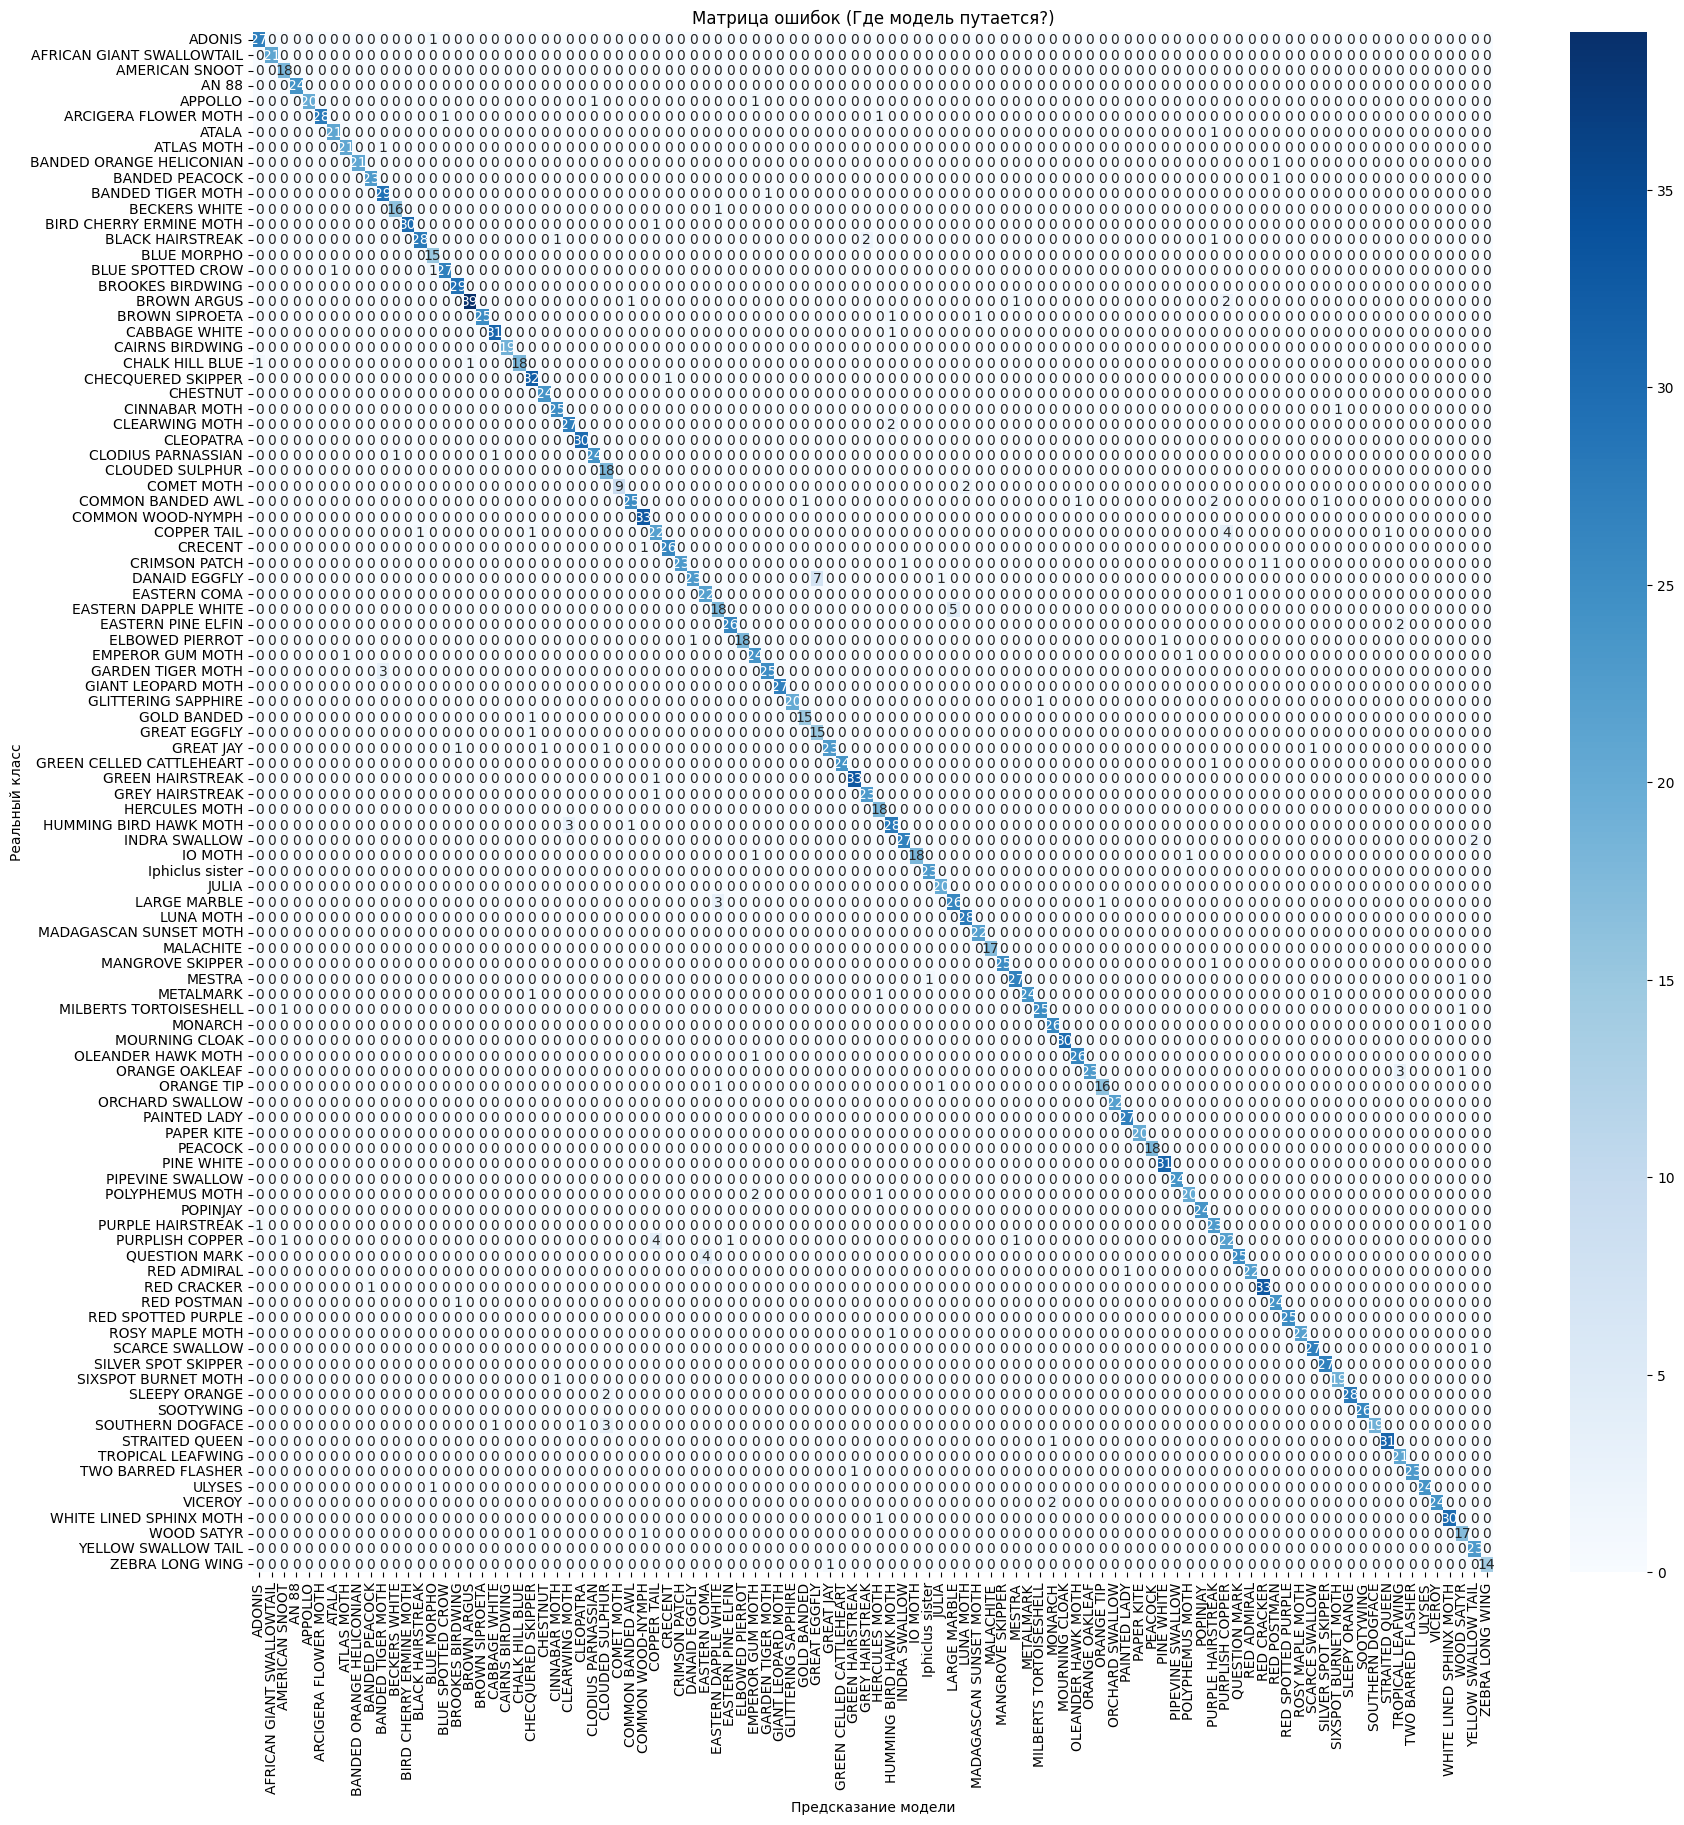

                           precision    recall  f1-score   support

                   ADONIS       0.93      0.96      0.95        28
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00        21
           AMERICAN SNOOT       0.90      1.00      0.95        18
                    AN 88       1.00      1.00      1.00        24
                  APPOLLO       1.00      0.91      0.95        22
     ARCIGERA FLOWER MOTH       1.00      0.93      0.97        30
                    ATALA       0.95      0.95      0.95        22
               ATLAS MOTH       0.95      0.95      0.95        22
 BANDED ORANGE HELICONIAN       1.00      0.95      0.98        22
           BANDED PEACOCK       0.96      0.96      0.96        24
        BANDED TIGER MOTH       0.88      0.97      0.92        30
            BECKERS WHITE       0.94      0.94      0.94        17
  BIRD CHERRY ERMINE MOTH       1.00      0.97      0.98        31
         BLACK HAIRSTREAK       0.97      0.88      0.92     

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("Генерация предсказаний для анализа")
y_pred = []
y_true = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Предсказание модели')
plt.ylabel('Реальный класс')
plt.title('Матрица ошибок (Где модель путается?)')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


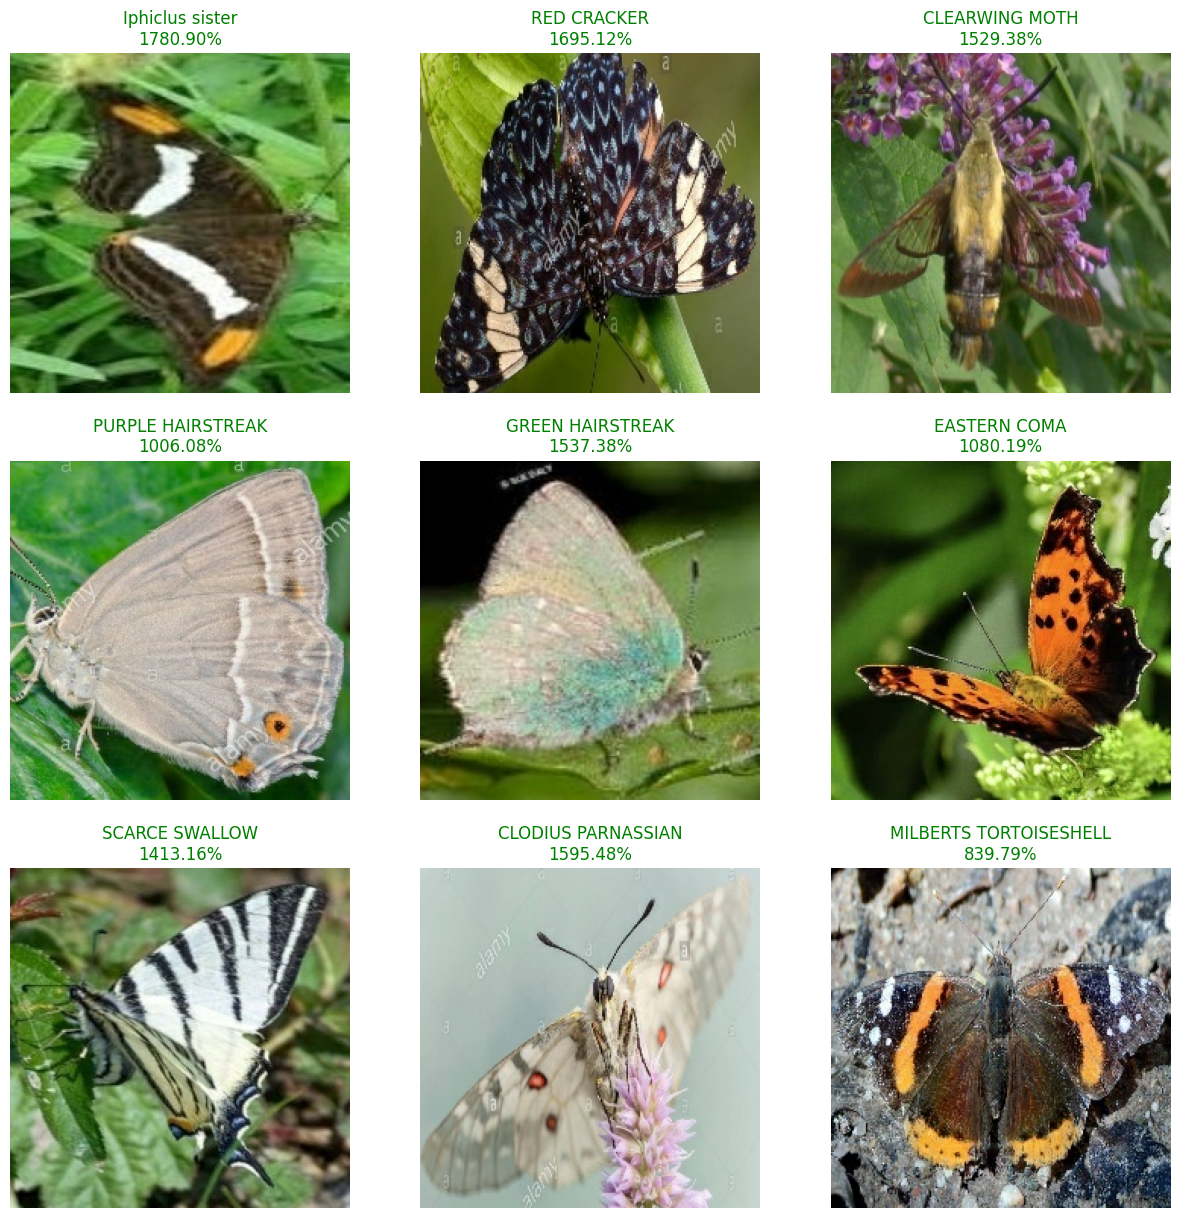

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in val_ds.take(1):
    predictions = model.predict(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_index = np.argmax(predictions[i])
        confidence = 100 * np.max(predictions[i])
        true_index = labels[i]


        if predicted_index == true_index:
            color = 'green'
            title = f"{class_names[predicted_index]}\n{confidence:.2f}%"
        else:
            color = 'red'
            title = f"Pred: {class_names[predicted_index]} ({confidence:.2f}%)\nTrue: {class_names[true_index]}"

        plt.title(title, color=color)
        plt.axis("off")

In [ ]:
import pickle

with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

    files.download('class_names.pkl')

print("Список классов сохранен")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Список классов сохранен! Скачайте файл class_names.pkl вместе с моделью.


In [ ]:
with open('class_names.pkl', 'rb') as f:
    loaded_class_names = pickle.load(f)